In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [3]:
def load_data(user_asset):
    data_path = os.path.join(os.getcwd(), 'dataset_out', user_asset)

    data_frames = {}
    for file in os.listdir(data_path):
        if(file.endswith('.csv')):
            file_path = os.path.join(data_path, file)
            stock = file.split('.')[0]
            data_frames[stock] = pd.read_csv(file_path)

    risk_data = data_frames['risk_data']
    risk_data.columns.values[0] = 'Ticker'
    del data_frames['risk_data']

    ### Convert Date column to datetime
    for stock, df in data_frames.items():
        df['Date'] = pd.to_datetime(df['Date'])
    
    return data_frames, risk_data

In [4]:
def preprocess_data(data_frames):
    scaler = MinMaxScaler()

    normalized_data_frames = {}
    for stock, df in data_frames.items():
        df_norm = df.copy()
        df_norm[df_norm.columns.values[1:]] = scaler.fit_transform(df_norm[df_norm.columns.values[1:]])
        normalized_data_frames[stock] = df_norm
    
    return normalized_data_frames

In [5]:
def generate_train_test_val_data(normalized_data_frames):
    ### Split data into train, test and val sets
    train_test_val_data = {}
    for stock, df in normalized_data_frames.items():
        train_df, test_df = train_test_split(df, test_size = 0.3, shuffle = False)
        test_df, val_df = train_test_split(test_df, test_size = 0.5, shuffle = False)

        """scaler = MinMaxScaler()
        train_df[train_df.columns.values[1:]] = scaler.fit_transform(train_df[train_df.columns.values[1:]])
        test_df[test_df.columns.values[1:]] = scaler.transform(test_df[test_df.columns.values[1:]])
        val_df[val_df.columns.values[1:]] = scaler.transform(val_df[val_df.columns.values[1:]])"""

        train_test_val_data[stock] = (train_df, test_df, val_df)
    return train_test_val_data

In [6]:
def generate_timeseries_windows(data, window_size = 10, forecast_range = 1, shift = 1):
    windows = []
    labels = []
    for xx in range(0, len(data) - window_size - forecast_range, shift):
        window = data[xx : xx + window_size + forecast_range]
        #if(len(window) == window_size + forecast_range):
        windows.append(window[:-forecast_range])
        labels.append(window[-1][4])
    return np.array(windows), np.array(labels)

In [7]:
def convert_to_tensor(train_data, train_labels, test_data, test_labels, val_data, val_labels):
    train_data_tensor = np.asarray(train_data, dtype=np.float32)
    train_data_tensor = torch.from_numpy(train_data_tensor)
    train_labels_tensor = torch.tensor(train_labels, dtype = torch.float32)

    test_data_tensor = np.asarray(test_data, dtype=np.float32)
    test_data_tensor = torch.from_numpy(test_data_tensor)
    test_labels_tensor = torch.tensor(test_labels, dtype = torch.float32)

    val_data_tensor = np.asarray(val_data, dtype=np.float32)
    val_data_tensor = torch.from_numpy(val_data_tensor)
    val_labels_tensor = torch.tensor(val_labels, dtype = torch.float32)

    return train_data_tensor, train_labels_tensor, test_data_tensor, test_labels_tensor, val_data_tensor, val_labels_tensor

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_layer_size=8, hidden_layer_size=256, num_layers=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_layer_size, hidden_layer_size, num_layers, batch_first = True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.linear(x[:, -1, :])
        return x

In [9]:
def load_model(user_asset, ticker):
    model_output_path = f"{os.getcwd()}/models/{user_asset}"
    model = LSTM()
    model.load_state_dict(torch.load(f"{model_output_path}/model_{ticker}.pt"))
    return model

In [10]:
def classification_metrics(test_labels_trend, output_single_stock_trend):
    ### Compute classification metrics
    accuracy = accuracy_score(test_labels_trend, output_single_stock_trend)
    precision = precision_score(test_labels_trend, output_single_stock_trend)
    recall = recall_score(test_labels_trend, output_single_stock_trend)
    f1 = f1_score(test_labels_trend, output_single_stock_trend)

    confusion_matrix_micro = confusion_matrix(test_labels_trend, output_single_stock_trend, labels=[True, False])
    TP = confusion_matrix_micro[1,1]
    TN = confusion_matrix_micro[0,0]
    FP = confusion_matrix_micro[0,1]
    FN = confusion_matrix_micro[1,0]

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN
    }

In [11]:
def plot_predictions(test_df, output_single_stock):
    plt.figure(figsize=(10, 6))
    plt.plot(test_df['Date'], test_df['Close'], label = 'Actual')
    plt.plot(test_df['Date'][len(test_df) - len(output_single_stock):], output_single_stock, label = 'Predicted')
    plt.xlabel('Days')
    plt.ylabel('Normalized Price')
    plt.title('Stock Price Prediction with LSTM')
    plt.legend()
    plt.show()

In [12]:
### Evaluate model
def evaluate_model(model, test_data_tensor, test_labels_tensor):
    ### Loss function
    criterion = nn.MSELoss()

    model.eval() # set model to evaluation mode

    with torch.no_grad():
        output = model(test_data_tensor)
        output = output.squeeze()
        test_loss = criterion(output, test_labels_tensor)
        #print("Test Loss: {:.6f}".format(test_loss))

    return output.squeeze().numpy()

In [13]:
### Evaluate model on single ticker
def eval_model(output_single_stock, val_df, val_labels, shortTerm = False, showResult = False):
    """
    Evaluates the model for a specific ticker and output

    Args:
        output_single_stock: prediction price values returned by the model; shape = (n, 1)
        val_df: the validation data, must contain 'Date' and 'Close' column
        val_labels: the labels of the validation set; shape = (m, 1)
    
    Returns:
        metric dictionary
    """
    if(shortTerm):
        val_labels_extended = val_labels
        val_labels = val_labels[21:]
    mse = mean_squared_error(val_labels, output_single_stock)
    r2 = r2_score(val_labels, output_single_stock)
    rmse = mean_squared_error(val_labels, output_single_stock, squared=False)

    if(shortTerm):
        test_labels_trend = (val_labels_extended[21:] > val_labels_extended[:-21])
        output_single_stock_trend = (output_single_stock > val_labels_extended[:-21])
    else:
        test_labels_trend = (val_labels[21:] > val_labels[:-21])
        output_single_stock_trend = (output_single_stock[21:] > val_labels[:-21])

    class_metrics = classification_metrics(test_labels_trend, output_single_stock_trend)

    if (showResult):
        print(('MSE: {}').format(mse))
        print(('Accuracy: {}').format(class_metrics['accuracy']))
        print(('Precision: {}').format(class_metrics['precision']))
        print(('Recall: {}').format(class_metrics['recall']))
        print(('F1: {}').format(class_metrics['f1']))
        ConfusionMatrixDisplay.from_predictions(test_labels_trend, output_single_stock_trend)
        plt.show()
        ### Plot predictions
        plot_predictions(val_df, output_single_stock)

    return {
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'accuracy': class_metrics['accuracy'],
        'precision': class_metrics['precision'],
        'recall': class_metrics['recall'],
        'f1': class_metrics['f1'],
        'TP': class_metrics['TP'],
        'TN': class_metrics['TN'],
        'FP': class_metrics['FP'],
        'FN': class_metrics['FN']
    }

In [47]:
### Evaluate model on multiple tickers
def eval_model_macro_micro(metrics_data):
    """
    Evaluates the model across all tickers by computing the macro-average of the metrics 

    Args:
        metrics_data: dictionary with ticker as key and the metrics dict obtained from eval_model as value
    
    Returns:
        Dictionary of macro-averaged metrics
    """
    macro_micro_metrics = {}
    metric_list = ['mse', 'rmse', 'r2', 'accuracy', 'precision', 'recall', 'f1']
    for metric in metric_list:
        macro_micro_metrics[metric] = np.mean([metrics_data[stock][metric] for stock in metrics_data.keys()])
    
    # rename accuracy, precision, recall and f1 with macro specifier
    macro_micro_metrics['macro_accuracy'] = macro_micro_metrics.pop('accuracy')
    macro_micro_metrics['macro_precision'] = macro_micro_metrics.pop('precision')
    macro_micro_metrics['macro_recall'] = macro_micro_metrics.pop('recall')
    macro_micro_metrics['macro_f1'] = macro_micro_metrics.pop('f1')

    metric_list = ['TP', 'TN', 'FP', 'FN']
    for metric in metric_list:
        macro_micro_metrics[metric] = np.sum([metrics_data[stock][metric] for stock in metrics_data.keys()])

    # compute micro metrics
    macro_micro_metrics['micro_accuracy'] = (macro_micro_metrics['TP'] + macro_micro_metrics['TN']) / (macro_micro_metrics['TP'] + macro_micro_metrics['TN'] + macro_micro_metrics['FP'] + macro_micro_metrics['FN'])
    macro_micro_metrics['micro_precision'] = macro_micro_metrics['TP'] / (macro_micro_metrics['TP'] + macro_micro_metrics['FP'])
    macro_micro_metrics['micro_recall'] = macro_micro_metrics['TP'] / (macro_micro_metrics['TP'] + macro_micro_metrics['FN'])
    macro_micro_metrics['micro_f1'] = 2 * macro_micro_metrics['micro_precision'] * macro_micro_metrics['micro_recall'] / (macro_micro_metrics['micro_precision'] + macro_micro_metrics['micro_recall'])
    
    return macro_micro_metrics

In [39]:
# try saved models
data_frames, risk_data = load_data('stock')
normalized_data_frames = preprocess_data(data_frames)
#feature_engineered_data_frames = feature_engineering(normalized_data_frames)
train_test_val_data = generate_train_test_val_data(normalized_data_frames)

### Peformance on validation set

In [53]:
### Evaluate macro performance on whole validation set
window_size = 90

metrics_data = {}

model_output_path = f"{os.getcwd()}/models/stock"

"""
for file in os.listdir(model_output_path):
    if(file.endswith('.pt')):
        stock = file.split('_')[1].split('.')[0]
"""

stock_selection_path = os.path.join(os.getcwd(), 'medium_risk_stocks_300.txt')
with open(stock_selection_path) as stocks:
    for stock in stocks:
        stock = stock.strip()
        _, test_df, val_df = train_test_val_data[stock]
        val_df = test_df
        model = load_model('stock', stock)

        val_data, val_labels = generate_timeseries_windows(val_df.values, window_size, shift = 1)

        val_data = np.delete(val_data, [0], axis = 2)
        val_data_tensor = np.asarray(val_data, dtype=np.float32)
        val_data_tensor = torch.from_numpy(val_data_tensor)
        val_labels_tensor = torch.tensor(val_labels, dtype = torch.float32)

        output_single_stock = evaluate_model(model, val_data_tensor, val_labels_tensor)
        
        metrics_data[stock] = eval_model(output_single_stock, val_df, val_labels)

metrics_data_overall = metrics_data
macro_micro_metrics = eval_model_macro_micro(metrics_data)
macro_micro_metrics

{'mse': 0.0006828485731404228,
 'rmse': 0.024649875667167632,
 'r2': 0.8374351629176391,
 'macro_accuracy': 0.8678156122315962,
 'macro_precision': 0.8545286092582376,
 'macro_recall': 0.8891545124780108,
 'macro_f1': 0.8669609557482181,
 'TP': 33869,
 'TN': 35067,
 'FP': 4184,
 'FN': 6297,
 'micro_accuracy': 0.8680257375624866,
 'micro_precision': 0.8900480908206975,
 'micro_recall': 0.843225613703132,
 'micro_f1': 0.8660044234776716}

Text(0.5, 1.0, 'Confusion Matrix for LSTM')

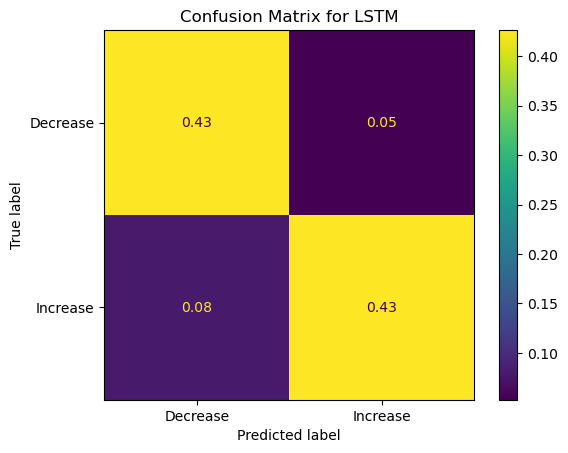

In [65]:
#Display confusion matrix
total = macro_micro_metrics['TP'] + macro_micro_metrics['TN'] + macro_micro_metrics['FP'] + macro_micro_metrics['FN']
conf_matrix = np.array([[macro_micro_metrics['TP'], macro_micro_metrics['FP']], [macro_micro_metrics['FN'], macro_micro_metrics['TP']]]) / total
dsp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Decrease', 'Increase'])
dsp.plot(values_format='.2f')
plt.title('Confusion Matrix for LSTM')

### Performance last 21 days + Ranked List

In [17]:
### Evaluate macro performance on last 21 days including ranked list
eval_days = 21
window_size = 90
metrics_data = {}
model_output_path = f"{os.getcwd()}/models/stock"
stock_selection_path = os.path.join(os.getcwd(), 'medium_risk_stocks_300.txt')

price_change_predictions = {}
price_change_actuals = {}

with open(stock_selection_path) as stocks:
    for stock in stocks:
        stock = stock.strip()
        _, _, val_df = train_test_val_data[stock]
        model = load_model('stock', stock)

        val_data, val_labels = generate_timeseries_windows(val_df.values, window_size, shift = 1)

        val_data = np.delete(val_data, [0], axis = 2)
        val_data_tensor = np.asarray(val_data, dtype=np.float32)
        val_data_tensor = torch.from_numpy(val_data_tensor)
        val_labels_tensor = torch.tensor(val_labels, dtype = torch.float32)

        val_data_tensor = val_data_tensor[-eval_days:]
        val_labels_tensor = val_labels_tensor[-eval_days:]
        val_labels = val_labels[-2*eval_days:]
        output_single_stock = output_single_stock[-eval_days:]
        val_df[-2*eval_days:]

        output_single_stock = evaluate_model(model, val_data_tensor, val_labels_tensor)
        metrics_data[stock] = eval_model(output_single_stock, val_df, val_labels, shortTerm=True)

        price_change_prediction = float ((output_single_stock[-1] - val_labels_tensor[-eval_days]) / val_labels_tensor[-eval_days])
        price_change_actual = float ((val_labels_tensor[-1] - val_labels_tensor[-eval_days]) / val_labels_tensor[-eval_days])

        price_change_predictions[stock] = price_change_prediction
        price_change_actuals[stock] = price_change_actual

macro_micro_metrics = eval_model_macro_micro(metrics_data)

ranked_stocks_lstm_path = os.path.join(os.getcwd(), f'ranked_stocks_300_lstm.txt')
ranked_stocks_actual_path = os.path.join(os.getcwd(), f'ranked_stocks_300_actual.txt')
with open(ranked_stocks_lstm_path, 'w') as file:
    for ticker, price_change in sorted(price_change_predictions.items(), key=lambda x: x[1], reverse=True):
        precision = metrics_data_overall[ticker]['precision']
        file.write(f"{ticker} ({round(precision, 2)}): {round(price_change, 3)} \n")
with open(ranked_stocks_actual_path, 'w') as file:
    for ticker, price_change in sorted(price_change_actuals.items(), key=lambda x: x[1], reverse=True):
        file.write(ticker + ": " + str(price_change) + "\n")

### Compare actual and predicted price changes
# number of elements in top
top = 30
threshold = 0.8
top_actuals = [ticker for ticker, _ in sorted(price_change_actuals.items(), key=lambda x: x[1], reverse=True)[:top]]

counter_in_actuals = 0
counter_above_threshold = 0
for ticker, _ in sorted(price_change_predictions.items(), key=lambda x: x[1], reverse=True)[:top]:
    if (metrics_data_overall[ticker]['precision'] > threshold):
        counter_above_threshold += 1
        if ticker in top_actuals:
            counter_in_actuals += 1

print(f"{counter_in_actuals} out of {counter_above_threshold} stocks with precision > {threshold} in the Top {top} of LSTM are in the top {top} actuals")
# number of elements in bottom
bottom = top
bottom_actuals = [ticker for ticker, _ in sorted(price_change_actuals.items(), key=lambda x: x[1], reverse=True)[-top:]]

counter_in_actuals = 0
counter_above_threshold = 0
for ticker, _ in sorted(price_change_predictions.items(), key=lambda x: x[1], reverse=True)[-top:]:
    if (metrics_data_overall[ticker]['precision'] > threshold):
        counter_above_threshold += 1
        if ticker in bottom_actuals:
            counter_in_actuals += 1

print(f"{counter_in_actuals} out of {counter_above_threshold} stocks with precision > {threshold} in the Bottom {bottom} of LSTM are in the bottom {bottom} actuals")

macro_micro_metrics


/Users/alexanderwolters/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexanderwolters/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexanderwolters/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/alexanderwolters/opt/anaco

18 out of 23 stocks with precision > 0.8 in the Top 30 of LSTM are in the top 30 actuals
19 out of 22 stocks with precision > 0.8 in the Bottom 30 of LSTM are in the bottom 30 actuals


{'mse': 0.001964864631726563,
 'rmse': 0.03254380896572853,
 'r2': -3.4109119008265947,
 'macro_accuracy': 0.8525396825396826,
 'macro_precision': 0.7723463861130269,
 'macro_recall': 0.836621150134695,
 'macro_f1': 0.7821663256962934,
 'TP': 1708,
 'TN': 3663,
 'FP': 313,
 'FN': 616,
 'micro_accuracy': 0.8525396825396825,
 'micro_precision': 0.8451261751608115,
 'micro_recall': 0.7349397590361446,
 'micro_f1': 0.7861910241657076}

### Single Stock Visualization

MSE: 0.002295319954870952
Accuracy: 0.650375939849624
Precision: 0.6265060240963856
Recall: 1.0
F1: 0.7703703703703704


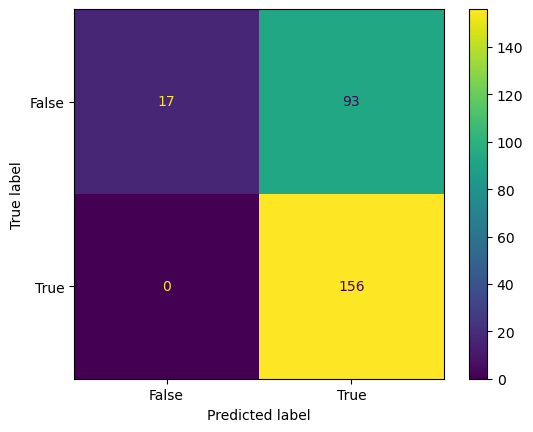

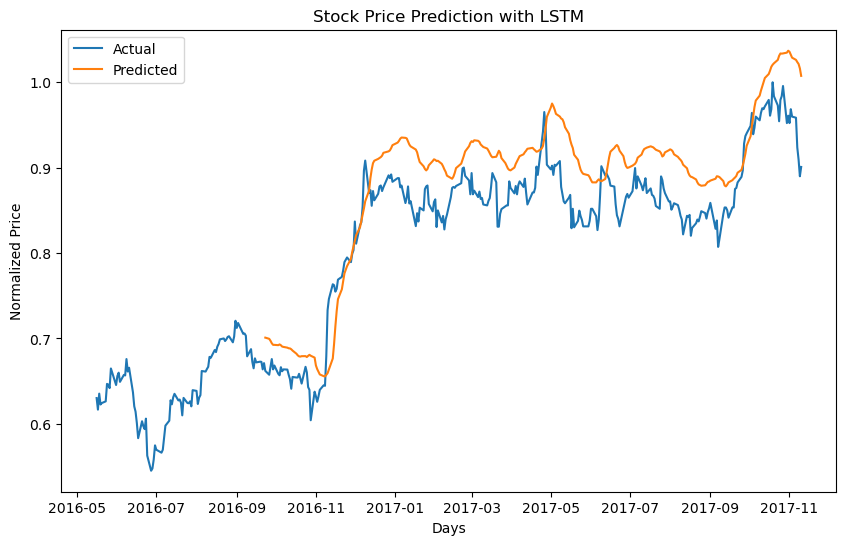

{'mse': 0.002295319954870952,
 'rmse': 0.047909497543503335,
 'r2': 0.670751468420834,
 'accuracy': 0.650375939849624,
 'precision': 0.6265060240963856,
 'recall': 1.0,
 'f1': 0.7703703703703704,
 'TP': 17,
 'TN': 156,
 'FP': 0,
 'FN': 93}

In [33]:
### Plot results of single stock
window_size = 90
model_output_path = f"{os.getcwd()}/models/stock"
ticker = 'WSFS'


_, _, val_df = train_test_val_data[ticker]
model = load_model('stock', ticker)

val_data, val_labels = generate_timeseries_windows(val_df.values, window_size, shift = 1)

val_data = np.delete(val_data, [0], axis = 2)
val_data_tensor = np.asarray(val_data, dtype=np.float32)
val_data_tensor = torch.from_numpy(val_data_tensor)
val_labels_tensor = torch.tensor(val_labels, dtype = torch.float32)

output_single_stock = evaluate_model(model, val_data_tensor, val_labels_tensor)

metrics_data = eval_model(output_single_stock, val_df, val_labels, shortTerm=False, showResult=True)

metrics_data

51.407
5.454


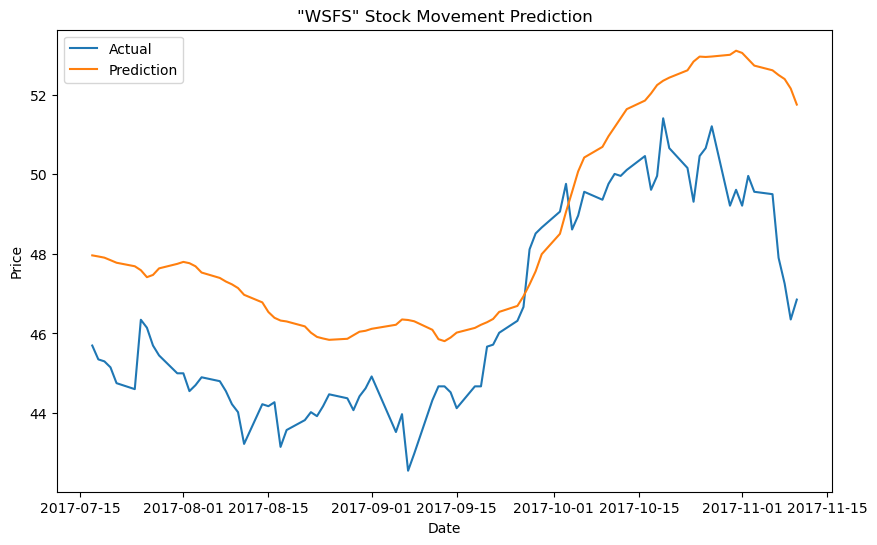

In [34]:
#plot for pppt output (with unnormalized data), starting from 2017-07-15
max = data_frames[ticker]['Close'].max()
min = data_frames[ticker]['Close'].min()
print(max)
print(min)
output_single_stock = output_single_stock * (max - min) + min
val_df['Close'] = val_df['Close'] * (max - min) + min
test_df = val_df

# starting from 2017-07-05
test_df = test_df[test_df['Date'] >= '2017-07-15']
output_single_stock = output_single_stock[-len(test_df):]

plt.figure(figsize=(10, 6))
plt.plot(test_df['Date'], test_df['Close'], label = 'Actual', color = 'tab:blue')
plt.plot(test_df['Date'], output_single_stock, label = 'Prediction', color = 'tab:orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'"{ticker}" Stock Movement Prediction')
plt.legend()
plt.show()

### Baseline Model Evaluation

In [66]:
### Evaluate macro performance on whole validation set
window = 21
metrics_data_base = {}

stock_selection_path = os.path.join(os.getcwd(), 'medium_risk_stocks_300.txt')
with open(stock_selection_path) as stocks:
    for stock in stocks:
        stock = stock.strip()
        _, _, val_df = train_test_val_data[stock]

        baseline_model_df = val_df.copy()
        baseline_model_df[f'{window}Day_MA'] = baseline_model_df['Close'].rolling(window=window).mean()
        baseline_model_df['Base Line Prediction'] = baseline_model_df[f'{window}Day_MA'].shift(21)
        
        output_single_stock = baseline_model_df['Base Line Prediction'].dropna()
        val_labels = baseline_model_df['Close'].loc[output_single_stock.index]
        output_single_stock = output_single_stock.reset_index(drop=True).values
        val_labels = val_labels.reset_index(drop=True).values
        
        metrics_data_base[stock] = eval_model(output_single_stock, val_df, val_labels)

macro_micro_metrics = eval_model_macro_micro(metrics_data_base)
macro_micro_metrics

{'mse': 0.00486347259223147,
 'rmse': 0.06708170111953528,
 'r2': 0.3284476441396253,
 'macro_accuracy': 0.5082411250449433,
 'macro_precision': 0.622658134527355,
 'macro_recall': 0.45306143087432604,
 'macro_f1': 0.5061944317594342,
 'TP': 24132,
 'TN': 23855,
 'FP': 30714,
 'FN': 15737,
 'micro_accuracy': 0.5081323196171033,
 'micro_precision': 0.43999562411114757,
 'micro_recall': 0.6052822995309639,
 'micro_f1': 0.5095708177163069}

Text(0.5, 1.0, 'Confusion Matrix for Baseline Model')

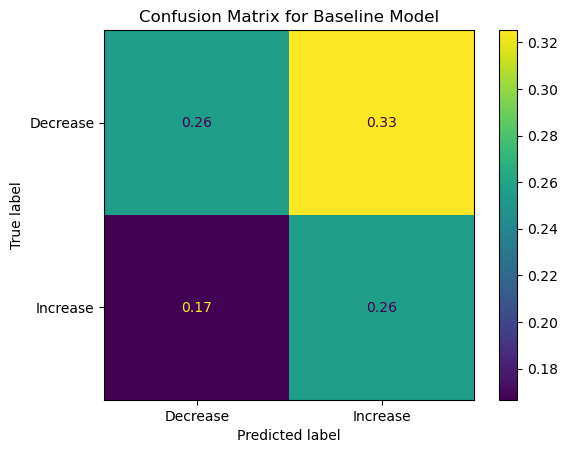

In [68]:
#Display confusion matrix
total = macro_micro_metrics['TP'] + macro_micro_metrics['TN'] + macro_micro_metrics['FP'] + macro_micro_metrics['FN']
conf_matrix = np.array([[macro_micro_metrics['TP'], macro_micro_metrics['FP']], [macro_micro_metrics['FN'], macro_micro_metrics['TP']]]) / total
dsp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Decrease', 'Increase'])
dsp.plot(values_format='.2f')
plt.title('Confusion Matrix for Baseline Model')

In [68]:
### Evaluate macro performance on last 21 days including ranked list
window = 21
eval_days = 21
metrics_data = {}
stock_selection_path = os.path.join(os.getcwd(), 'medium_risk_stocks_300.txt')

price_change_predictions_base = {}
#price_change_actuals_base = {}

with open(stock_selection_path) as stocks:
    for stock in stocks:
        stock = stock.strip()
        _, _, val_df = train_test_val_data[stock]

        baseline_model_df = val_df.copy()
        baseline_model_df[f'{window}Day_MA'] = baseline_model_df['Close'].rolling(window=window).mean()
        baseline_model_df['Base Line Prediction'] = baseline_model_df[f'{window}Day_MA'].shift(21)

        output_single_stock = baseline_model_df['Base Line Prediction'].dropna()
        val_labels = baseline_model_df['Close'].loc[output_single_stock.index]
        output_single_stock = output_single_stock.reset_index(drop=True).values
        val_labels = val_labels.reset_index(drop=True).values
        
        val_labels = val_labels[-eval_days:]
        output_single_stock = output_single_stock[-eval_days:]
        val_df = val_df[-2*eval_days:]

        metrics_data[stock] = eval_model(output_single_stock, val_df, val_labels)

        price_change_prediction_base = float ((output_single_stock[-1] - val_labels[-eval_days]) / val_labels[-eval_days])
        #price_change_actual_base = float ((val_labels[-1] - val_labels[-eval_days]) / val_labels[-eval_days])

        price_change_predictions_base[stock] = price_change_prediction_base
        #price_change_actuals_base[stock] = price_change_actual_base

macro_metrics = eval_model_macro(metrics_data)

ranked_stocks_base_path = os.path.join(os.getcwd(), f'ranked_stocks_300_base.txt')
with open(ranked_stocks_base_path, 'w') as file:
    for ticker, price_change in sorted(price_change_predictions_base.items(), key=lambda x: x[1], reverse=True):
        file.write(ticker + ": " + str(price_change) + "\n")

### Compare actual and predicted price changes
# number of elements in top
top = 30
top_actuals = [ticker for ticker, _ in sorted(price_change_actuals.items(), key=lambda x: x[1], reverse=True)[:top]]

counter = 0
for ticker, _ in sorted(price_change_predictions_base.items(), key=lambda x: x[1], reverse=True)[:top]:
    if ticker in top_actuals:
        counter += 1

print(counter)
# number of elements in bottom
bottom = top
bottom_actuals = [ticker for ticker, _ in sorted(price_change_actuals.items(), key=lambda x: x[1], reverse=True)[-top:]]

counter = 0
for ticker, _ in sorted(price_change_predictions_base.items(), key=lambda x: x[1], reverse=True)[-top:]:
    if ticker in bottom_actuals:
        counter += 1

print(counter)

macro_metrics

/Users/alexanderwolters/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexanderwolters/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexanderwolters/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexanderwolters/opt/anaconda3/lib/python3.9/site-

0
3


/Users/alexanderwolters/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/alexanderwolters/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexanderwolters/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexanderwolters/opt/anaconda3/lib

{'mse': 0.006982268356101749,
 'rmse': 0.0719140654943193,
 'r2': -14.539191437538591,
 'accuracy': 0.53,
 'precision': 0.09,
 'recall': 0.09,
 'f1': 0.09}

MSE: 0.005582173941450199
Accuracy: 0.6107594936708861
Precision: 0.7014925373134329
Recall: 0.5310734463276836
F1: 0.6045016077170419


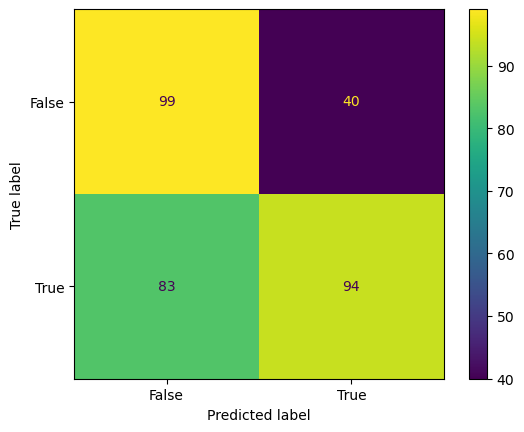

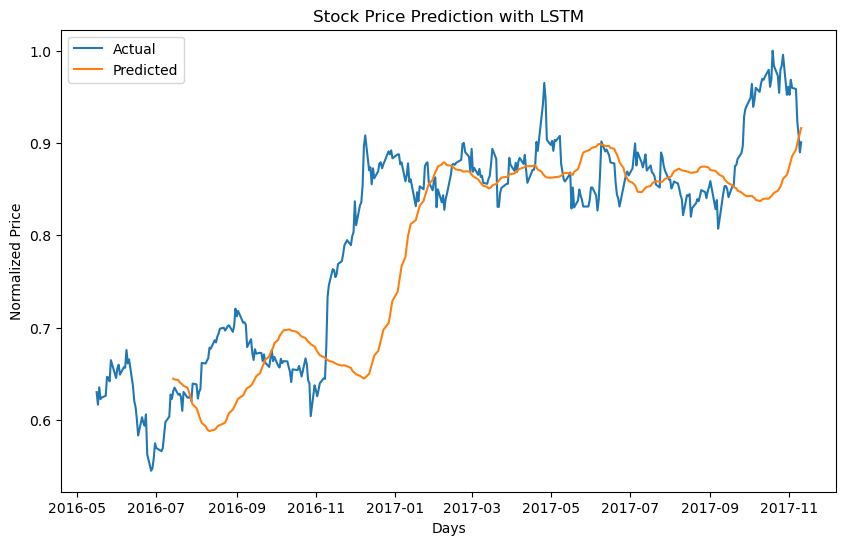

{'mse': 0.005582173941450199,
 'rmse': 0.0747139474358717,
 'r2': 0.4409868219480637,
 'accuracy': 0.6107594936708861,
 'precision': 0.7014925373134329,
 'recall': 0.5310734463276836,
 'f1': 0.6045016077170419,
 'TP': 99,
 'TN': 94,
 'FP': 83,
 'FN': 40}

In [37]:
### Plot results of single stock
ticker = 'WSFS'
window = 21
_, _, val_df = train_test_val_data[ticker]

baseline_model_df = val_df.copy()
baseline_model_df[f'{window}Day_MA'] = baseline_model_df['Close'].rolling(window=window).mean()
baseline_model_df['Base Line Prediction'] = baseline_model_df[f'{window}Day_MA'].shift(21)

output_single_stock = baseline_model_df['Base Line Prediction'].dropna()
val_labels = baseline_model_df['Close'].loc[output_single_stock.index]
output_single_stock = output_single_stock.reset_index(drop=True).values
val_labels = val_labels.reset_index(drop=True).values

metrics_data = eval_model(output_single_stock, val_df, val_labels, shortTerm=False, showResult=True)

metrics_data

51.407
5.454


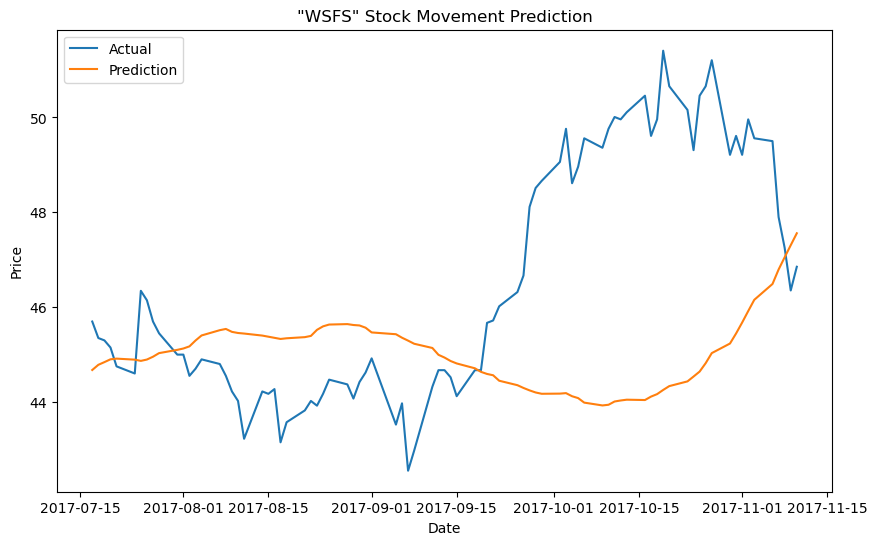

In [38]:
#plot for pppt output (with unnormalized data), starting from 2017-07-15
max = data_frames[ticker]['Close'].max()
min = data_frames[ticker]['Close'].min()
print(max)
print(min)
output_single_stock = output_single_stock * (max - min) + min
val_df['Close'] = val_df['Close'] * (max - min) + min
test_df = val_df

# starting from 2017-07-05
test_df = test_df[test_df['Date'] >= '2017-07-15']
output_single_stock = output_single_stock[-len(test_df):]

plt.figure(figsize=(10, 6))
plt.plot(test_df['Date'], test_df['Close'], label = 'Actual', color = 'tab:blue')
plt.plot(test_df['Date'], output_single_stock, label = 'Prediction', color = 'tab:orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'"{ticker}" Stock Movement Prediction')
plt.legend()
plt.show()